# AuxTel - M1 Mirror Motion - Closed Dome Tests
by Patrick Ingraham, modified by Bruno Quint.

This notebooks looks at primary mirror motion as a function of elevation. This is used verify the mirror doesn't lift when we go below the LUT. Data obtained mainly on 2021-08-17.

## Import Libraries

In [1]:
import asyncio 
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from astropy.time import Time, TimeDelta
from IPython.display import FileLink, FileLinks
from lsst_efd_client import EfdClient, rendezvous_dataframes

%matplotlib inline

## Set up Logger

In [2]:
import logging
from lsst.ts.observing.utilities.decorated_logger import DecoratedLogger

logger = DecoratedLogger.get_decorated_logger()
logger.level = logging.DEBUG

logging.getLogger("matplotlib").level = logging.INFO

## Set up EFD Client

In [3]:
efd_client = EfdClient('summit_efd')
#efd_client = EfdClient('ldf_stable_efd') 

  [D 2021-08-31 18:12:50 urllib3.connectionpool]  Starting new HTTPS connection (1): roundtable.lsst.codes:443
  [D 2021-08-31 18:12:51 urllib3.connectionpool]  https://roundtable.lsst.codes:443 "GET /segwarides/ HTTP/1.1" 200 253
  [D 2021-08-31 18:12:51 urllib3.connectionpool]  Starting new HTTPS connection (1): roundtable.lsst.codes:443
  [D 2021-08-31 18:12:52 urllib3.connectionpool]  https://roundtable.lsst.codes:443 "GET /segwarides/creds/summit_efd HTTP/1.1" 200 160
  [D 2021-08-31 18:12:52 urllib3.connectionpool]  Starting new HTTPS connection (1): influxdb-summit-efd.lsst.codes:443
  [D 2021-08-31 18:12:53 urllib3.connectionpool]  https://influxdb-summit-efd.lsst.codes:443 "GET /health HTTP/1.1" 200 106


Query for all the `endReadout` events on the timespan of the night, elevation, and pmd data

## Set up time range

In [4]:
date = '20210819'
test = 'verify_no_lift_at_low_elev'
run = 'test9'

# Starting Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test
# start time is 2021-08-17T17:36:43.64
if run == 'test1': 
    t1 = Time("2021-08-17T17:36:45", format='isot', scale='tai')
    t2 = Time("2021-08-17T17:45:00.386", format='isot', scale='tai')
    scale_factor=1.0
    start_log_msg = '[2021-07-08_Repeat_Focus_Test_START]'
    finish_log_msg = '[2021-07-08_Repeat_Focus_Test_END]'

# Starting Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test
# start time is 2021-08-17T18:52:18.40
elif run == 'test2':
    t1 = Time("2021-08-17T18:52:18.40", format='isot', scale='tai')
    t2 = Time("2021-08-17T18:58:41.773", format='isot', scale='tai')

# Starting Test3, Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test, minimum adjusted higher
# start time is 2021-08-17T19:13:07.588
elif run == 'test3':
    t1 = Time("2021-08-17T19:13:07.588", format='isot', scale='tai')
    t2 = Time("2021-08-17T19:18:50.310", format='isot', scale='tai') 

# Starting Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test
# start time is 2021-08-17T17:36:43.64
elif run == 'test4':
    t1 = Time("2021-08-17T20:45:16.148", format='isot', scale='tai')
    t2 = Time("2021-08-17T20:50:39.174", format='isot', scale='tai') 

#Starting Test16, Nominal LUT from m1_hex_20210810_v3.yaml:v0.8.2.alpha.2-0-g72c6e32, low elevation test ED
elif run == 'test5':
    t1 = Time("2021-08-19T23:21:30.379", format='isot', scale='tai')
    t2 = Time("2021-08-19T23:25:59.912", format='isot', scale='tai')

#ATAOS on, but with 45K PA limit
elif run == 'test6':
    t1 = Time("2021-08-19T23:48:18.697", format='isot', scale='tai')
    t2 = Time("2021-08-19T23:51:54.218", format='isot', scale='tai')

# New ATAOS Model - Pressure limit 45 kPa
elif run == 'test7':
    t1 = Time("2021-08-26T17:14:36.290", format='isot', scale='tai')
    t2 = Time("2021-08-26T17:21:10.819", format='isot', scale='tai')

# Pressure limit 41.5 kPa
elif run == 'test8':
    t1 = Time("2021-08-26T18:29:10.446", format='isot', scale='tai')
    t2 = Time("2021-08-26T18:40:00.000", format='isot', scale='tai')
    
# Pressure limit 41.5 kPa
elif run == 'test8':
    t1 = Time("2021-08-26T18:29:10.446", format='isot', scale='tai')
    t2 = Time("2021-08-26T18:40:00.000", format='isot', scale='tai')

# Pressure limit 41.5 kPa - Sanity Test - From 45deg to 27deg.
elif run == 'test9':
    t1 = Time("2021-08-26T18:45:22", format='isot', scale='tai')
    t2 = Time("2021-08-26T18:49:29", format='isot', scale='tai')

else:
    raise IOError('Not a valid input')

In [5]:
# # # day of 2021-07-08 - Test3 run with scalefactor = 1.02  - not sure this was great, so redid it
# t1 = Time("2021-08-09T16:42:32.166", format='isot', scale='tai')
# t2 = Time("2021-08-09T16:48:41.015", format='isot', scale='tai')

In [6]:
# # # day of 2021-07-08 - Test4 run with scalefactor = 1.04 - ignore, redoing
# t1 = Time("2021-08-09T16:50:24.872", format='isot', scale='tai')
# t2 = Time("2021-08-09T16:59:24.872", format='isot', scale='tai')

In [7]:
# # day of 2021-07-08 - Test4 (didn't increment) run with scalefactor = 1.06 = BAD - Sensor dropped out
# t1 = Time("2021-08-09T16:59:24.872", format='isot', scale='tai')
# t2 = Time("2021-08-09T17:05:32.895", format='isot', scale='tai')

## Querying log messages

In [8]:
df_log_message = await efd_client.select_time_series(
    "lsst.sal.Script.logevent_logMessage", ["message","level"], t1, t2)

df_log_message

  [D 2021-08-31 18:12:58 aioinflux]  200: SELECT message, level FROM "efd"."autogen"."lsst.sal.Script.logevent_logMessage" WHERE time >= '2021-08-26T18:45:22.000Z' AND time <= '2021-08-26T18:49:29.000Z'


,message,level
2021-08-26 18:45:23.437000+00:00,Starting Alpha .5 AOS model elevation test. Te...,20
2021-08-26 18:45:35.827000+00:00,"az,el,pos0,pos1,pos2 = 0, 45, 0.006, 0.088, 0....",20
2021-08-26 18:45:55.207000+00:00,"az,el,pos0,pos1,pos2 = 0, 42, 0.012, 0.092, 0....",20
2021-08-26 18:46:14.493000+00:00,"az,el,pos0,pos1,pos2 = 0, 39, 0.018, 0.096, 0....",20
2021-08-26 18:46:33.873000+00:00,"az,el,pos0,pos1,pos2 = 0, 36, 0.024, 0.101, 0....",20
2021-08-26 18:46:53.069000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.03, 0.106, 0.0...",20
2021-08-26 18:47:12.638000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.037, 0.11, 0.0...",20
2021-08-26 18:47:31.927000+00:00,"az,el,pos0,pos1,pos2 = 0, 27, 0.042, 0.114, 0....",20
2021-08-26 18:47:51.311000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.043, 0.114, 0....",20
2021-08-26 18:48:10.597000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.113, 0....",20


## Query Elevation

In [9]:
df_elevation = await efd_client.select_packed_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", ["elevationCalculatedAngle1", ], t1, t2)

# mount reporting incorrect timestamp for the packed time series
df_elevation.index = df_elevation.index + pd.tseries.offsets.DateOffset(seconds=-37)
df_elevation.index = pd.to_datetime(df_elevation.index).tz_localize('Etc/UCT')
df_elevation = df_elevation.resample('1s').median()

  [D 2021-08-31 18:13:00 aioinflux]  200: SHOW FIELD KEYS FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders"
  [D 2021-08-31 18:13:00 aioinflux]  200: SELECT elevationCalculatedAngle10, elevationCalculatedAngle11, elevationCalculatedAngle12, elevationCalculatedAngle13, elevationCalculatedAngle14, elevationCalculatedAngle15, elevationCalculatedAngle16, elevationCalculatedAngle17, elevationCalculatedAngle18, elevationCalculatedAngle19, cRIO_timestamp FROM "efd"."autogen"."lsst.sal.ATMCS.mount_AzEl_Encoders" WHERE time >= '2021-08-26T18:45:22.000Z' AND time <= '2021-08-26T18:49:29.000Z'
  [I 2021-08-31 18:13:00 numexpr.utils]  Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
  [I 2021-08-31 18:13:00 numexpr.utils]  NumExpr defaulting to 8 threads.


In [10]:
df_elevation

,elevationCalculatedAngle1,times
2021-08-26 18:45:21+00:00,44.999794,1.630004e+09
2021-08-26 18:45:22+00:00,44.999835,1.630004e+09
2021-08-26 18:45:23+00:00,44.999880,1.630004e+09
2021-08-26 18:45:24+00:00,45.000417,1.630004e+09
2021-08-26 18:45:25+00:00,45.000493,1.630004e+09
...,...,...
2021-08-26 18:49:23+00:00,45.000033,1.630004e+09
2021-08-26 18:49:24+00:00,45.000027,1.630004e+09
2021-08-26 18:49:25+00:00,45.000020,1.630004e+09
2021-08-26 18:49:26+00:00,45.000015,1.630004e+09


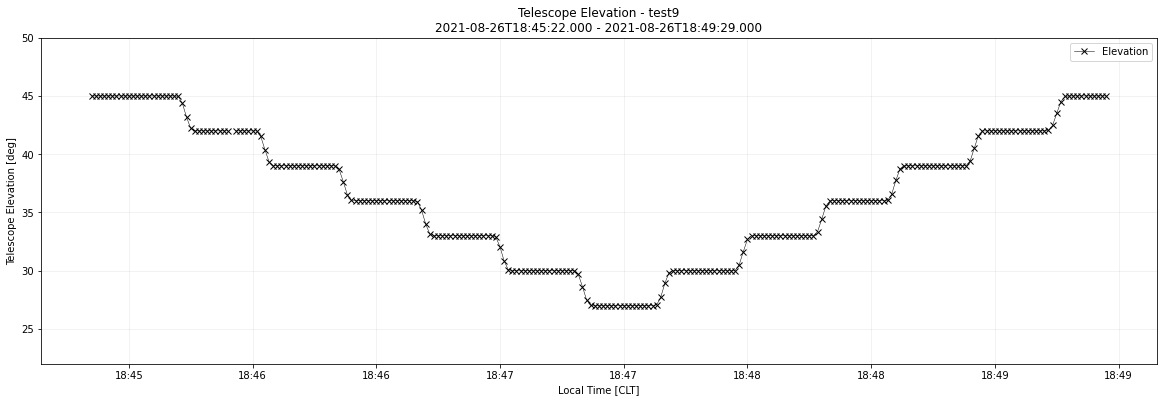

In [11]:
%matplotlib inline
fig, ax = plt.subplots(num='Elevation', figsize=(20, 6))

ax.plot(df_elevation.index, df_elevation['elevationCalculatedAngle1'], 
        'kx-', label='Elevation', lw=0.5)

ax.set_ylim(df_elevation['elevationCalculatedAngle1'].min() - 5, 
            df_elevation['elevationCalculatedAngle1'].max() + 5)

ax.grid('-', alpha=0.2)
ax.set_xlabel('Local Time [CLT]')
ax.set_ylabel('Telescope Elevation [deg]')
ax.legend()
ax.set_title(f'Telescope Elevation - {run}\n{t1} - {t2}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.show()

## Query PMD

Precision Measurement Devices - these are the Mitutoyo Micrometers.

In [12]:
df_pmd = await efd_client.select_time_series(
    "lsst.sal.PMD.position", 
    ["position0", "position1", "position2", "position3", "position5"], t1, t2)

# We are only insterested in relative values
df_pmd = df_pmd - df_pmd.iloc[0]
# df_pmd = df_pmd.resample('1s').median().interpolate(method='polynomial', order=1)

  [D 2021-08-31 18:13:04 aioinflux]  200: SELECT position0, position1, position2, position3, position5 FROM "efd"."autogen"."lsst.sal.PMD.position" WHERE time >= '2021-08-26T18:45:22.000Z' AND time <= '2021-08-26T18:49:29.000Z'


In [13]:
df_pmd

,position0,position1,position2,position3,position5
2021-08-26 18:45:23.756000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-26 18:45:25.466000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-26 18:45:27.271000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-26 18:45:28.981000+00:00,0.000,0.000,0.000,0.000,0.000
2021-08-26 18:45:30.692000+00:00,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...
2021-08-26 18:49:21.184000+00:00,0.027,0.017,-0.004,-0.003,0.005
2021-08-26 18:49:22.800000+00:00,0.027,0.017,-0.004,-0.003,0.004
2021-08-26 18:49:24.605000+00:00,0.027,0.017,-0.003,-0.003,0.004
2021-08-26 18:49:26.315000+00:00,0.027,0.017,-0.003,-0.003,0.004


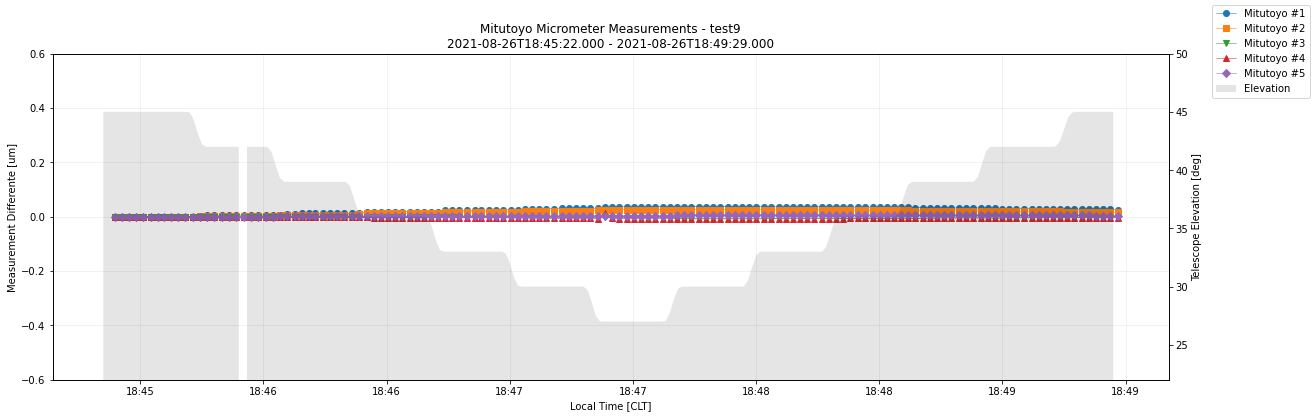

In [14]:
%matplotlib inline
fig, ax = plt.subplots(num='PMD', figsize=(20, 6))

ax.plot(df_pmd.index, df_pmd['position0'], 'C0o-', label='Mitutoyo #1', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position1'], 'C1s-', label='Mitutoyo #2', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position2'], 'C2v-', label='Mitutoyo #3', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position3'], 'C3^-', label='Mitutoyo #4', lw=0.5)
ax.plot(df_pmd.index, df_pmd['position5'], 'C4D-', label='Mitutoyo #5', lw=0.5)

ax.grid('-', alpha=0.2)
ax.set_xlabel('Local Time [CLT]')
ax.set_ylabel('Measurement Differente [um]')
ax.set_ylim(-0.6, 0.6)
ax.set_title(f'Mitutoyo Micrometer Measurements - {run}\n{t1} - {t2}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax.twinx()
ax2.fill_between(df_elevation.index, 0, 
                df_elevation['elevationCalculatedAngle1'], zorder=-10, 
                label='Elevation', fc='black', lw=0.5, alpha=0.1)
ax2.set_ylim(df_elevation['elevationCalculatedAngle1'].min() - 5, 
            df_elevation['elevationCalculatedAngle1'].max() + 5, )
ax2.set_ylabel('Telescope Elevation [deg]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.legend()
fig.savefig(f'./plots/mit_measurements_{run}_{t1}_{t2}.png', 
            facecolor='white', edgecolor='none')
plt.show()

del fig, ax, ax2

In [15]:
FileLink(f'./mit_measurements_{run}_{t1}_{t2}.png')

/scratch/bquint/notebooks/AuxTel/mit_measurements_test9_2021-08-26T18:45:22.000_2021-08-26T18:49:29.000.png

## Query ATM1 Air Pressure

In [16]:
df_pressure = await efd_client.select_time_series(
    "lsst.sal.ATPneumatics.m1AirPressure", ["pressure"], t1, t2)
df_pressure = df_pressure.resample('1s').median()

  [D 2021-08-31 18:13:09 aioinflux]  200: SELECT pressure FROM "efd"."autogen"."lsst.sal.ATPneumatics.m1AirPressure" WHERE time >= '2021-08-26T18:45:22.000Z' AND time <= '2021-08-26T18:49:29.000Z'


In [17]:
df_pressure

,pressure
2021-08-26 18:45:22+00:00,77368.263306
2021-08-26 18:45:23+00:00,77389.304443
2021-08-26 18:45:24+00:00,77389.304443
2021-08-26 18:45:25+00:00,77303.035779
2021-08-26 18:45:26+00:00,77389.304443
...,...
2021-08-26 18:49:24+00:00,77389.304443
2021-08-26 18:49:25+00:00,77303.035779
2021-08-26 18:49:26+00:00,77410.345581
2021-08-26 18:49:27+00:00,77345.118054


In [18]:
df_atpneumatics_commands = await efd_client.select_time_series("lsst.sal.ATPneumatics.command_m1SetPressure", ["pressure"], t1, t2)
df_atpneumatics_commands = df_atpneumatics_commands.rename(columns={'pressure': 'pressure_cmd_atpneumatics'})
df_atpneumatics_commands = df_atpneumatics_commands.resample('1s').median()

  [D 2021-08-31 18:13:10 aioinflux]  200: SELECT pressure FROM "efd"."autogen"."lsst.sal.ATPneumatics.command_m1SetPressure" WHERE time >= '2021-08-26T18:45:22.000Z' AND time <= '2021-08-26T18:49:29.000Z'


In [19]:
df_atpneumatics_commands

,pressure_cmd_atpneumatics
2021-08-26 18:45:22+00:00,78084.242901
2021-08-26 18:45:23+00:00,78084.312134
2021-08-26 18:45:24+00:00,78084.867215
2021-08-26 18:45:25+00:00,78084.945957
2021-08-26 18:45:26+00:00,78084.977150
...,...
2021-08-26 18:49:24+00:00,78084.558330
2021-08-26 18:49:25+00:00,78084.553005
2021-08-26 18:49:26+00:00,78084.548440
2021-08-26 18:49:27+00:00,78084.544636


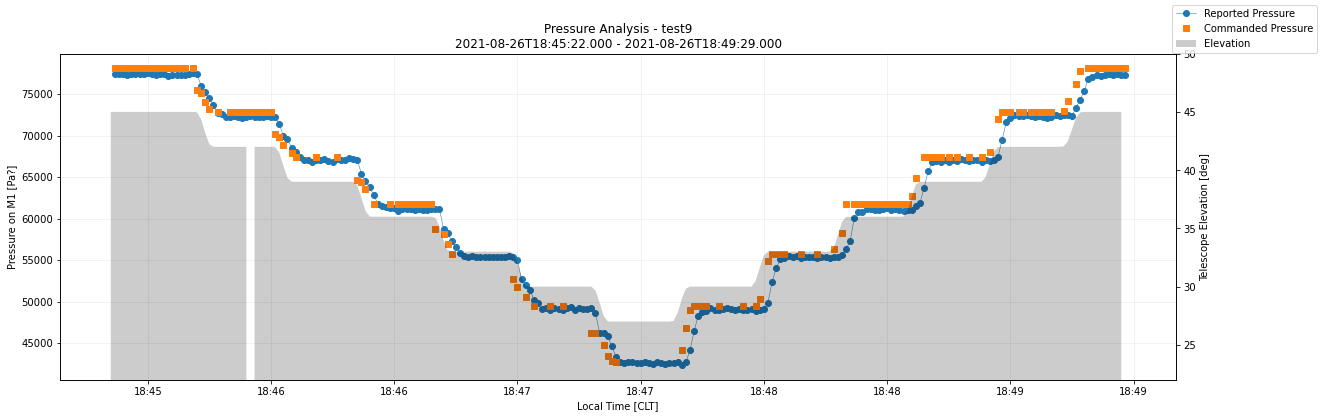

In [20]:
%matplotlib inline
fig, ax = plt.subplots(num='PMD', figsize=(20, 6))

ax.plot(df_pressure.index, df_pressure['pressure'], 'C0o-', 
        label='Reported Pressure', lw=0.5, zorder=3)
ax.plot(df_atpneumatics_commands.index, 
        df_atpneumatics_commands['pressure_cmd_atpneumatics'], 
        'C1s', label='Commanded Pressure', lw=0.5, zorder=3)
ax.grid('-', alpha=0.2)
ax.set_xlabel('Local Time [CLT]')
ax.set_ylabel('Pressure on M1 [Pa?]')
ax.set_title(f'Pressure Analysis - {run}\n{t1} - {t2}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax2 = ax.twinx()
ax2.fill_between(df_elevation.index, 0, 
                df_elevation['elevationCalculatedAngle1'], 
                label='Elevation', fc='black', lw=0.5, alpha=0.2)
ax2.set_ylim(df_elevation['elevationCalculatedAngle1'].min() - 5, 
            df_elevation['elevationCalculatedAngle1'].max() + 5, )
ax2.set_ylabel('Telescope Elevation [deg]')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.legend()
fig.savefig(f'./plots/pressure_{run}_{t1}_{t2}.png', 
            facecolor='white', edgecolor='none')
plt.show()

del fig, ax, ax2

## Old Stuff

The following contents are part of the original notebook and I did not update them yet. I am keeping everything to clean it up later.

## Joining DataFrames

In [21]:
df_log_message

,message,level
2021-08-26 18:45:23.437000+00:00,Starting Alpha .5 AOS model elevation test. Te...,20
2021-08-26 18:45:35.827000+00:00,"az,el,pos0,pos1,pos2 = 0, 45, 0.006, 0.088, 0....",20
2021-08-26 18:45:55.207000+00:00,"az,el,pos0,pos1,pos2 = 0, 42, 0.012, 0.092, 0....",20
2021-08-26 18:46:14.493000+00:00,"az,el,pos0,pos1,pos2 = 0, 39, 0.018, 0.096, 0....",20
2021-08-26 18:46:33.873000+00:00,"az,el,pos0,pos1,pos2 = 0, 36, 0.024, 0.101, 0....",20
2021-08-26 18:46:53.069000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.03, 0.106, 0.0...",20
2021-08-26 18:47:12.638000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.037, 0.11, 0.0...",20
2021-08-26 18:47:31.927000+00:00,"az,el,pos0,pos1,pos2 = 0, 27, 0.042, 0.114, 0....",20
2021-08-26 18:47:51.311000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.043, 0.114, 0....",20
2021-08-26 18:48:10.597000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.113, 0....",20


In [22]:
tmp = rendezvous_dataframes(df_log_message, df_elevation)
tmp = rendezvous_dataframes(tmp, df_pmd)
tmp = rendezvous_dataframes(tmp, df_pressure)
tmp = rendezvous_dataframes(tmp, df_atpneumatics_commands)
raw_data = tmp

In [23]:
raw_data

,message,level,elevationCalculatedAngle1,times,position0,position1,position2,position3,position5,pressure,pressure_cmd_atpneumatics
2021-08-26 18:45:23.437000+00:00,Starting Alpha .5 AOS model elevation test. Te...,20,44.999880,1.630004e+09,NaN,NaN,NaN,NaN,NaN,77389.304443,78084.312134
2021-08-26 18:45:35.827000+00:00,"az,el,pos0,pos1,pos2 = 0, 45, 0.006, 0.088, 0....",20,44.999959,1.630004e+09,0.000,0.000,0.000,0.000,0.000,77214.663000,78084.462773
2021-08-26 18:45:55.207000+00:00,"az,el,pos0,pos1,pos2 = 0, 42, 0.012, 0.092, 0....",20,NaN,NaN,0.006,0.004,-0.001,-0.001,0.000,72312.077917,72873.199509
2021-08-26 18:46:14.493000+00:00,"az,el,pos0,pos1,pos2 = 0, 39, 0.018, 0.096, 0....",20,39.000029,1.630004e+09,0.012,0.008,-0.002,-0.002,0.001,66950.796033,NaN
2021-08-26 18:46:33.873000+00:00,"az,el,pos0,pos1,pos2 = 0, 36, 0.024, 0.101, 0....",20,36.000021,1.630004e+09,0.018,0.013,-0.002,-0.003,0.001,61090.839185,61750.275089
2021-08-26 18:46:53.069000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.03, 0.106, 0.0...",20,32.999994,1.630004e+09,0.024,0.018,-0.003,-0.004,0.002,55403.419666,NaN
2021-08-26 18:47:12.638000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.037, 0.11, 0.0...",20,30.000016,1.630004e+09,0.031,0.022,-0.004,-0.006,0.002,49171.034680,NaN
2021-08-26 18:47:31.927000+00:00,"az,el,pos0,pos1,pos2 = 0, 27, 0.042, 0.114, 0....",20,26.999967,1.630004e+09,0.036,0.026,-0.004,-0.007,0.003,42721.925977,NaN
2021-08-26 18:47:51.311000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.043, 0.114, 0....",20,29.999994,1.630004e+09,0.037,0.026,-0.006,-0.008,0.007,49192.075818,NaN
2021-08-26 18:48:10.597000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.113, 0....",20,32.999992,1.630004e+09,0.036,0.025,-0.005,-0.007,0.007,55403.419666,NaN


In [24]:
raw_data = raw_data.drop_duplicates(
    subset=['elevationCalculatedAngle1', 'message', 'pressure'])

print(raw_data[['elevationCalculatedAngle1','pressure']])

                                  elevationCalculatedAngle1      pressure
2021-08-26 18:45:23.437000+00:00                  44.999880  77389.304443
2021-08-26 18:45:35.827000+00:00                  44.999959  77214.663000
2021-08-26 18:45:55.207000+00:00                        NaN  72312.077917
2021-08-26 18:46:14.493000+00:00                  39.000029  66950.796033
2021-08-26 18:46:33.873000+00:00                  36.000021  61090.839185
2021-08-26 18:46:53.069000+00:00                  32.999994  55403.419666
2021-08-26 18:47:12.638000+00:00                  30.000016  49171.034680
2021-08-26 18:47:31.927000+00:00                  26.999967  42721.925977
2021-08-26 18:47:51.311000+00:00                  29.999994  49192.075818
2021-08-26 18:48:10.597000+00:00                  32.999992  55403.419666
2021-08-26 18:48:28.366000+00:00                  35.999940  61067.693933
2021-08-26 18:48:47.556000+00:00                  38.999989  66929.754895
2021-08-26 18:49:07.128000+00:00      

In [25]:
raw_data

,message,level,elevationCalculatedAngle1,times,position0,position1,position2,position3,position5,pressure,pressure_cmd_atpneumatics
2021-08-26 18:45:23.437000+00:00,Starting Alpha .5 AOS model elevation test. Te...,20,44.999880,1.630004e+09,NaN,NaN,NaN,NaN,NaN,77389.304443,78084.312134
2021-08-26 18:45:35.827000+00:00,"az,el,pos0,pos1,pos2 = 0, 45, 0.006, 0.088, 0....",20,44.999959,1.630004e+09,0.000,0.000,0.000,0.000,0.000,77214.663000,78084.462773
2021-08-26 18:45:55.207000+00:00,"az,el,pos0,pos1,pos2 = 0, 42, 0.012, 0.092, 0....",20,NaN,NaN,0.006,0.004,-0.001,-0.001,0.000,72312.077917,72873.199509
2021-08-26 18:46:14.493000+00:00,"az,el,pos0,pos1,pos2 = 0, 39, 0.018, 0.096, 0....",20,39.000029,1.630004e+09,0.012,0.008,-0.002,-0.002,0.001,66950.796033,NaN
2021-08-26 18:46:33.873000+00:00,"az,el,pos0,pos1,pos2 = 0, 36, 0.024, 0.101, 0....",20,36.000021,1.630004e+09,0.018,0.013,-0.002,-0.003,0.001,61090.839185,61750.275089
2021-08-26 18:46:53.069000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.03, 0.106, 0.0...",20,32.999994,1.630004e+09,0.024,0.018,-0.003,-0.004,0.002,55403.419666,NaN
2021-08-26 18:47:12.638000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.037, 0.11, 0.0...",20,30.000016,1.630004e+09,0.031,0.022,-0.004,-0.006,0.002,49171.034680,NaN
2021-08-26 18:47:31.927000+00:00,"az,el,pos0,pos1,pos2 = 0, 27, 0.042, 0.114, 0....",20,26.999967,1.630004e+09,0.036,0.026,-0.004,-0.007,0.003,42721.925977,NaN
2021-08-26 18:47:51.311000+00:00,"az,el,pos0,pos1,pos2 = 0, 30, 0.043, 0.114, 0....",20,29.999994,1.630004e+09,0.037,0.026,-0.006,-0.008,0.007,49192.075818,NaN
2021-08-26 18:48:10.597000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.113, 0....",20,32.999992,1.630004e+09,0.036,0.025,-0.005,-0.007,0.007,55403.419666,NaN


In [26]:
# from scipy import linalg
arr_len = len(raw_data.position0)
coeff_arr = np.zeros((arr_len,3))
theta_arr = np.zeros((arr_len))
phi_arr = np.zeros((arr_len))
piston_arr = np.zeros((arr_len))
for i in np.arange(arr_len):
    # X, Y, Z
    set2=np.array((  41.0, 468.0, (raw_data.position2[i])))
    set3=np.array(( 384.0,-269.0, (raw_data.position3[i])))
    set4=np.array((-425.0,-198.0, (raw_data.position5[i])))

    # Vector PQ crossed with Vector PR
    normal = np.cross(set3-set2,set4-set2) # gives a,b,c

    D= -normal[0]*set2[0] - normal[1]*set2[1] - normal[2]*set2[2]  # Constant in plane equation
    # equation 
    
    phi_from_normal = (np.pi/2+np.arctan2(normal[2], normal[1])) * 206265
    theta_from_normal = (np.pi/2+np.arctan2(normal[2], normal[0])) * 206265
    # find z at the origin to represent piston
    Z_origin = -D/normal[2]
    
    # Measure rotation about the Y-axis (perpendicular to elevation)
    # So this is TIP and should result in motion in azimuth
    # get slope by looking at Y=0, X=400
    x_pt=400; y_pt=0
    #Z_at_x_pt= C[0]*x_pt + C[1]*0.0 + C[2]
    Z_at_x_pt= (-D - normal[0]*x_pt - normal[1]*0.0)/normal[2]
    theta = np.arctan2(Z_at_x_pt-Z_origin, x_pt) * 206265 # arcsec
        
    # Measure rotation about the X-axis (aligned to elevation)
    # this is TILT and should result in motion in elevation
    # get slope by looking at Y=0, X=400    
    x_pt=0; y_pt=400
    Z_at_y_pt= (-D - normal[0]*x_pt - normal[1]*y_pt)/normal[2]
    phi = np.arctan2(Z_at_y_pt-Z_origin, y_pt) * 206265 # arcsec

    theta_arr[i] = theta # arcsec
    phi_arr[i] = phi    # arcsec
    piston_arr[i] = Z_origin
    
    print(f'theta_from_normal is {theta_from_normal:0.2f}, phi_from_normal is {phi_from_normal:0.2f}')
    print(f'theta_arr is {theta_arr[i]:0.2f} [arcsec], phi_arr is {phi_arr[i]:0.2f} [arcsec]')

theta_from_normal is nan, phi_from_normal is nan
theta_arr is nan [arcsec], phi_arr is nan [arcsec]
theta_from_normal is 0.00, phi_from_normal is 0.00
theta_arr is -0.00 [arcsec], phi_arr is -0.00 [arcsec]
theta_from_normal is -0.27, phi_from_normal is -0.12
theta_arr is -0.27 [arcsec], phi_arr is -0.12 [arcsec]
theta_from_normal is -0.80, phi_from_normal is -0.37
theta_arr is -0.80 [arcsec], phi_arr is -0.37 [arcsec]
theta_from_normal is -1.04, phi_from_normal is -0.20
theta_arr is -1.04 [arcsec], phi_arr is -0.20 [arcsec]
theta_from_normal is -1.57, phi_from_normal is -0.45
theta_arr is -1.57 [arcsec], phi_arr is -0.45 [arcsec]
theta_from_normal is -2.08, phi_from_normal is -0.41
theta_arr is -2.08 [arcsec], phi_arr is -0.41 [arcsec]
theta_from_normal is -2.58, phi_from_normal is -0.36
theta_arr is -2.58 [arcsec], phi_arr is -0.36 [arcsec]
theta_from_normal is -3.94, phi_from_normal is -1.27
theta_arr is -3.94 [arcsec], phi_arr is -1.27 [arcsec]
theta_from_normal is -3.67, phi_from_n

In [27]:
import copy
calc_data=copy.copy(raw_data)
calc_data['m1_tip']=theta_arr
calc_data['m1_tilt']=phi_arr
calc_data['m1_piston']=piston_arr

calc_data['m1_y_pos']=(raw_data.position0)*np.cos(10*np.pi/180)
calc_data['m1_x_pos']=(raw_data.position1)*np.cos(10*np.pi/180)

In [116]:
calc_data

,message,level,elevationCalculatedAngle1,times,position0,position1,position2,position3,position5,pressure,pressure_cmd_atpneumatics,m1_tip,m1_tilt,m1_piston,m1_y_pos,m1_x_pos
2021-08-19 23:48:33.160000+00:00,"az,el,pos0,pos1,pos2 = 0, 43, -0.006, 0.136, 0...",20,42.999980,1.629417e+09,0.000,0.000,0.000,0.000,0.000,75013.759998,NaN,-0.000000,-0.000000,0.000000,0.000000,0.000000
2021-08-19 23:48:54.057000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.008, 0.144, 0....",20,38.000000,1.629417e+09,0.014,0.008,0.002,-0.005,0.000,65208.589832,65571.443513,-1.149844,1.423960,-0.001002,0.013787,0.007878
2021-08-19 23:49:13.329000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.021, 0.151, 0....",20,32.999945,1.629417e+09,0.027,0.015,0.001,-0.005,0.002,55315.046887,NaN,-1.707093,0.884745,-0.000668,0.026590,0.014772
2021-08-19 23:49:34.036000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.031, 0.157, 0....",20,27.999995,1.629417e+09,0.037,0.021,-0.001,-0.006,0.004,44617.732483,NaN,-2.530162,0.221817,-0.001000,0.036438,0.020681
2021-08-19 23:49:54.839000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.039, 0.162, 0....",20,22.999946,1.629417e+09,0.045,0.026,-0.004,-0.008,0.008,32914.651697,NaN,-4.150692,-0.812249,-0.001332,0.044316,0.025605
2021-08-19 23:50:13.635000+00:00,"az,el,pos0,pos1,pos2 = 0, 18, 0.045, 0.166, 0....",20,17.999930,1.629417e+09,0.051,0.030,-0.007,-0.010,0.007,NaN,NaN,-4.442120,-1.227751,-0.003331,0.050225,0.029544
2021-08-19 23:50:32.622000+00:00,"az,el,pos0,pos1,pos2 = 0, 23, 0.045, 0.166, 0....",20,23.000074,1.629417e+09,0.051,0.030,-0.008,-0.010,0.003,32468.579578,NaN,-3.404447,-1.024689,-0.004998,0.050225,0.029544
2021-08-19 23:50:53.710000+00:00,"az,el,pos0,pos1,pos2 = 0, 28, 0.044, 0.165, 0....",20,28.000032,1.629417e+09,0.050,0.029,-0.006,-0.008,0.002,44659.814758,NaN,-2.606986,-0.653550,-0.003999,0.049240,0.028559
2021-08-19 23:51:14.511000+00:00,"az,el,pos0,pos1,pos2 = 0, 33, 0.042, 0.163, 0....",20,33.000005,1.629417e+09,0.048,0.027,-0.005,-0.007,0.004,55348.712708,NaN,-2.872807,-0.777263,-0.002665,0.047271,0.026590
2021-08-19 23:51:33.405000+00:00,"az,el,pos0,pos1,pos2 = 0, 38, 0.038, 0.161, 0....",20,38.000062,1.629417e+09,0.044,0.025,-0.004,-0.006,0.003,64947.679724,65571.500257,-2.341166,-0.529837,-0.002332,0.043332,0.024620


In [117]:
#write data to disk
filename=date+'_'+test+"_"+run+"_metadata.csv"
calc_data.to_csv(filename)

Text(0.5, 0, 'Pressure [Pa]')

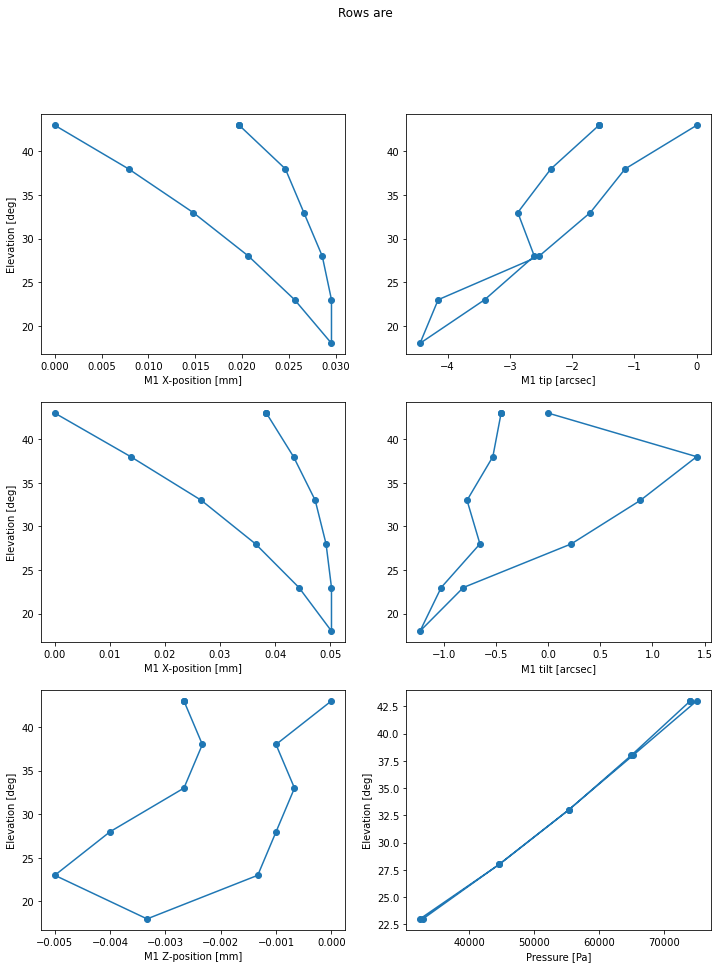

In [118]:
fig_height=5
fig_width=10
nwide=2; nhigh=3
fig, (row1,row2,row3) = plt.subplots(nhigh, nwide, figsize=(nwide+fig_width, nhigh*fig_height))
fig.suptitle('Rows are')
xvals = (calc_data.m1_x_pos) # um
yvals = calc_data.elevationCalculatedAngle1

row1[0].plot(xvals, yvals, 'o-')
row1[0].set_ylabel('Elevation [deg]')
row1[0].set_xlabel('M1 X-position [mm]')

xvals = (calc_data.m1_tip) # um
row1[1].plot(xvals, yvals, 'o-')
row1[1].set_xlabel('M1 tip [arcsec]')

xvals = (calc_data.m1_y_pos) # mm
row2[0].plot(xvals, yvals, 'o-')
row2[0].set_ylabel('Elevation [deg]')
row2[0].set_xlabel('M1 X-position [mm]')

xvals = (calc_data.m1_tilt) # um
row2[1].plot(xvals, yvals, 'o-')
row2[1].set_xlabel('M1 tilt [arcsec]')

xvals = (calc_data.m1_piston) # mm
row3[0].plot(xvals, yvals, 'o-')
row3[0].set_ylabel('Elevation [deg]')
row3[0].set_xlabel('M1 Z-position [mm]')

xvals = (calc_data.pressure) # mm
row3[1].plot(xvals, yvals, 'o-')
row3[1].set_ylabel('Elevation [deg]')
row3[1].set_xlabel('Pressure [Pa]')

In [ ]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     hex_elevation

# Now overplot the datasets

In [ ]:
# import itertools
# import matplotlib.cm as cm
# from matplotlib import colors
# runs = ['initial','test3b','test4b','test5b','test6','test7','test8','test9','test10','test11','test12','test13','test14','test15']
# #sym= ['.-','x-','triangle_up-']

# marker = itertools.cycle((',-', '+--', 'x-', 'v-', '*-')) 
# #colors=['red','blue','green']
# colors = cm.rainbow(np.linspace(0, 1, len(runs)))
# df={}

# scale_factors={'run':[], 'scale_factor':[]}
# fig_height=10
# fig_width=20

# %matplotlib inline

# nwide=3; nhigh=2
# fig, (row1,row2) = plt.subplots(nhigh, nwide, figsize=(nwide+fig_width, nhigh*fig_height))
# #fig.suptitle('Rows are')

# for i,r in enumerate(runs):
#     filename=date+'_'+test+"_"+r+"_metadata.csv"
# #     print(filename)
#     df[r] = pd.read_csv(filename, index_col=0)
#     df[r].index=pd.to_datetime(df[r].index)
#     # drop duplicates, not sure why there are double logs..
#     df[r].drop_duplicates(subset=['elevationCalculatedAngle1','message','pressure'])

#     if r =='initial':
#         starting_pressure = df[r].pressure[0]

#     scale_factor = 1-(df[r].pressure[0]-starting_pressure)/starting_pressure
#     scale_factors['run'].append(r)
#     scale_factors['scale_factor'].append(scale_factor)

# #     print(f'ratio is {scale_factor:0.3f} for {r}')
    
#     xvals = (df[r].m1_x_pos) # um
#     yvals = df[r].elevationCalculatedAngle1
#     sym=next(marker)
#     label = f'{r} {scale_factor:0.3f}'
#     color=colors[i]
#     row1[0].plot(xvals, yvals, sym, color=color, label=label)
#     row1[0].set_ylabel('Elevation [deg]')
#     row1[0].set_xlabel('M1 X-position [mm]')
    
#     xvals = (df[r].m1_y_pos) # mm
#     row1[1].plot(xvals, yvals, sym, color=color, label=label)
#     row1[1].set_ylabel('Elevation [deg]')
#     row1[1].set_xlabel('M1 Y-position [mm]')

#     xvals = (df[r].m1_piston) # mm
#     row1[2].plot(xvals, yvals, sym, color=color, label=label)
#     row1[2].set_ylabel('Elevation [deg]')
#     row1[2].set_xlabel('M1 Z-position [mm]')

#     row1[2].legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    
#     xvals = (df[r].m1_tip) # um   - Tip should mean azimuth motion
#     row2[0].plot(xvals, yvals, sym, color=color, label=label)
#     row2[0].set_xlabel('M1 tip [arcsec]')
#     row2[0].legend(bbox_to_anchor=(1.05, 1), loc='upper right', borderaxespad=0.)
    
#     xvals = (df[r].m1_tilt) # um
#     row2[1].plot(xvals, yvals, sym, color=color, label=label)
#     row2[1].set_xlabel('M1 tilt [arcsec]')

#     xvals = (df[r].pressure) # um   - Tip should mean azimuth motion
#     row2[2].plot(xvals, yvals, sym, color=color, label=label)
#     row2[2].set_xlabel('Pressure [Pa]')

In [ ]:
tmp1 = rendezvous_dataframes(pressure, el)
tmp = rendezvous_dataframes(tmp1,atpneumatics_commands)
xvals=tmp['elevationCalculatedAngle1']
yvals=tmp['pressure']
plt.plot(xvals, yvals, '.')
yvals=tmp['pressure_cmd_atpneumatics']
plt.plot(xvals, yvals, '-', color='orange')
plt.ylabel('Elevation [deg]')
plt.xlabel('Pressure [Pa]')

In [ ]:
tmp

In [ ]:
atpneumatics_commands